In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import ShuffleSplit
import seaborn as sns
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error as MSE
# model evaluation
from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV)
%matplotlib inline 

# data preprocessing
from sklearn.preprocessing import RobustScaler

# scikit-learn pipelines
from sklearn.pipeline import make_pipeline

# models
from sklearn.linear_model import (Lasso, LassoCV, Ridge,ElasticNet)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('Real_Estate_data.csv')
prices = data['SalePrice']
features = data.drop('SalePrice', axis = 1)

data.head(5)

,SalePrice,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),...,N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,2007,8,814,3,terraced,individual_heating,management_in_trust,111.0,...,1.0,1.0,0.0,3.0,2.0,2.0,2.0,5,6.0,9.0
1,51327,1985,2007,8,587,8,corridor,individual_heating,self_management,80.0,...,1.0,2.0,1.0,2.0,1.0,1.0,0.0,3,12.0,4.0
2,48672,1985,2007,8,587,6,corridor,individual_heating,self_management,80.0,...,1.0,2.0,1.0,2.0,1.0,1.0,0.0,3,12.0,4.0
3,380530,2006,2007,8,2056,8,terraced,individual_heating,management_in_trust,249.0,...,1.0,0.0,0.0,2.0,2.0,1.0,2.0,5,3.0,7.0
4,221238,1993,2007,8,1761,3,mixed,individual_heating,management_in_trust,523.0,...,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0


# 1. Exploratory Data Analysis

In [3]:
data.dtypes

SalePrice                               int64
YearBuilt                               int64
YrSold                                  int64
MonthSold                               int64
Size(sqf)                               int64
Floor                                   int64
HallwayType                            object
HeatingType                            object
AptManageType                          object
N_Parkinglot(Ground)                  float64
N_Parkinglot(Basement)                float64
TimeToBusStop                          object
TimeToSubway                           object
N_APT                                 float64
N_manager                             float64
N_elevators                           float64
SubwayStation                          object
N_FacilitiesNearBy(PublicOffice)      float64
N_FacilitiesNearBy(Hospital)            int64
N_FacilitiesNearBy(Dpartmentstore)    float64
N_FacilitiesNearBy(Mall)              float64
N_FacilitiesNearBy(ETC)           

In [4]:
# Dataframe dimensions
data.shape

(5891, 30)

In [5]:
# Filter only categorical data
data.dtypes[data.dtypes == 'object']

HallwayType      object
HeatingType      object
AptManageType    object
TimeToBusStop    object
TimeToSubway     object
SubwayStation    object
dtype: object

In [6]:
# Change float values to Int

float_data = data.dtypes[data.dtypes == 'float64'].index

for i in float_data:
    data[i] = data[i].apply(np.int64) #.astype(int)

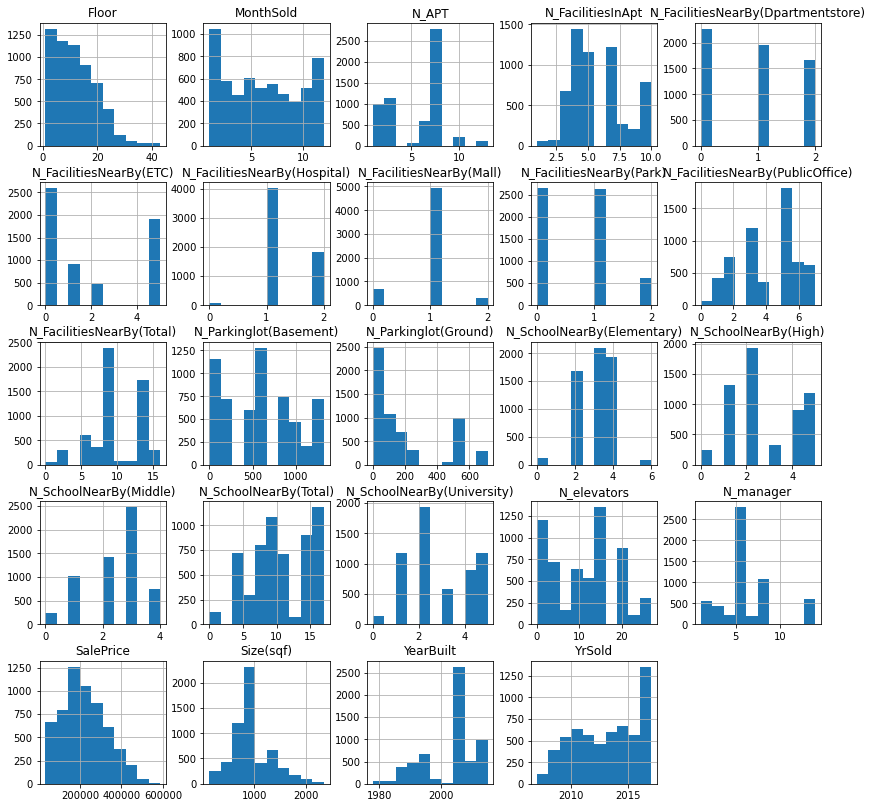

In [7]:
# Plot histogram grid
data.hist(figsize=(14,14))

# Clear the text "residue"
plt.show()

In [8]:
# Summarize numerical features
data.describe()

,SalePrice,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_APT,N_manager,...,N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
count,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,...,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000
mean,221218.112545,2002.967408,2012.691563,6.160244,955.569173,12.026311,195.883551,570.761670,5.613648,6.310304,...,0.941436,1.941266,0.654218,3.022407,2.417756,2.659311,2.764726,5.809540,9.870820,10.864200
std,106384.186446,8.811782,2.905488,3.387752,382.464050,7.548743,218.597210,408.621075,2.811831,3.174088,...,0.401355,2.201392,0.658320,0.954575,1.037898,1.556041,1.489289,2.330804,3.450319,4.438513
min,32743.000000,1978.000000,2007.000000,1.000000,135.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,144247.000000,1993.000000,2010.000000,3.000000,644.000000,6.000000,11.000000,184.000000,3.000000,5.000000,...,1.000000,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,4.000000,8.000000,7.000000
50%,207964.000000,2006.000000,2013.000000,6.000000,910.000000,11.000000,100.000000,536.000000,7.000000,6.000000,...,1.000000,1.000000,1.000000,3.000000,3.000000,2.000000,2.000000,5.000000,9.000000,10.000000
75%,291150.000000,2008.000000,2015.000000,9.000000,1149.000000,17.000000,249.000000,798.000000,8.000000,8.000000,...,1.000000,5.000000,1.000000,4.000000,3.000000,4.000000,4.000000,7.000000,13.000000,15.000000
max,585840.000000,2015.000000,2017.000000,12.000000,2337.000000,43.000000,713.000000,1321.000000,13.000000,14.000000,...,2.000000,5.000000,2.000000,6.000000,4.000000,5.000000,5.000000,10.000000,16.000000,17.000000


In [9]:
# Summarize categorical features
data.describe(include=['object'])

,HallwayType,HeatingType,AptManageType,TimeToBusStop,TimeToSubway,SubwayStation
count,5891,5891,5891,5891,5891,5891
unique,3,2,2,3,5,8
top,terraced,individual_heating,management_in_trust,0~5min,0-5min,Kyungbuk_uni_hospital
freq,3564,5591,5542,4509,2759,1644


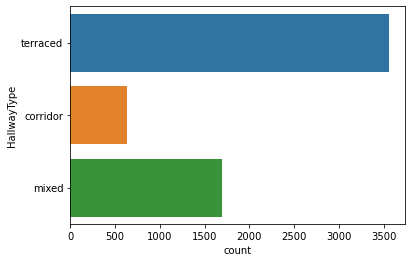

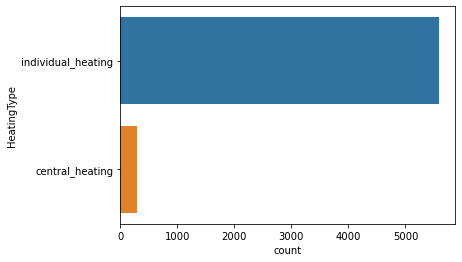

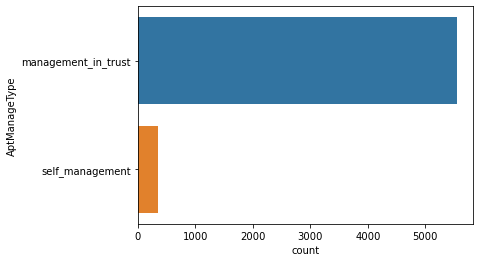

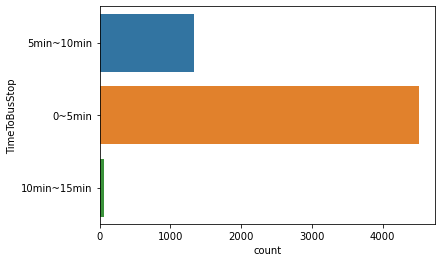

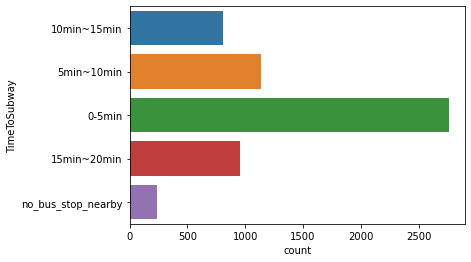

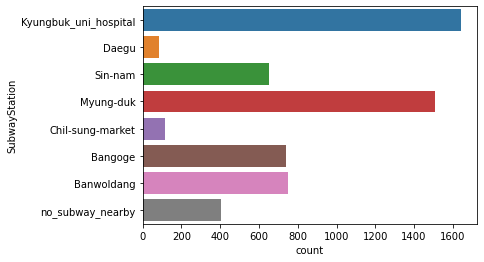

In [10]:
# Plot bar plot for each categorical feature
categorical = data.select_dtypes(include='object')
for feature in categorical:
    sns.countplot(y=feature, data=data)
    plt.show()

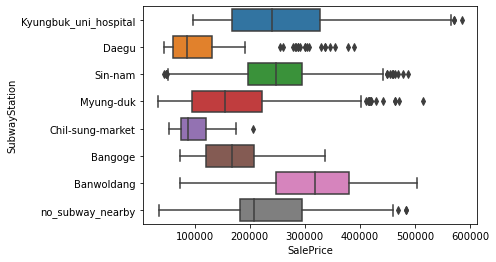

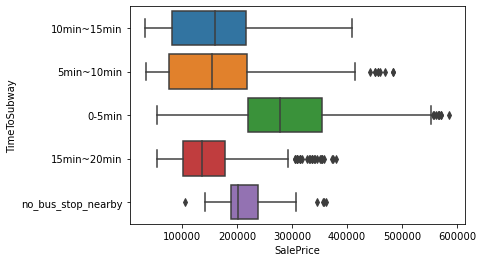

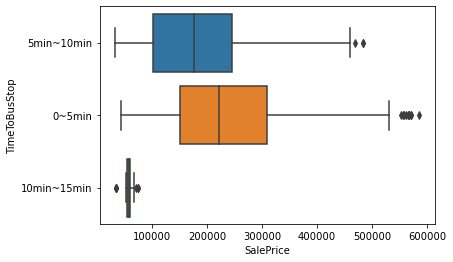

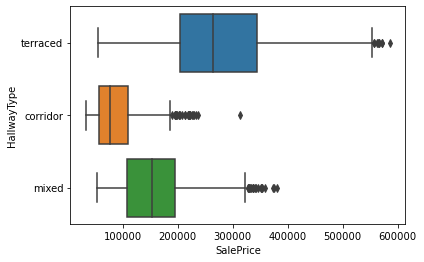

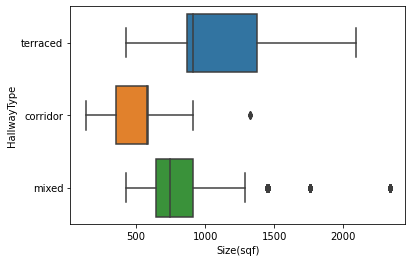

,SalePrice,YearBuilt,YrSold,MonthSold,Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_APT,N_manager,N_elevators,...,N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
Size(sqf),,,,,,,,,,,,,,,,,,,,,
135,52994.846154,2014.0,2015.346154,6.884615,15.000000,0.0,218.0,1.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,1.0
138,55309.500000,2014.0,2016.000000,8.000000,18.500000,0.0,218.0,1.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,1.0
156,60172.333333,2014.0,2015.571429,5.333333,14.190476,0.0,218.0,1.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,1.0
160,58849.000000,2014.0,2015.000000,7.000000,19.000000,0.0,218.0,1.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,1.0
163,60176.000000,2014.0,2015.000000,1.000000,13.000000,0.0,218.0,1.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1796,294012.941176,1986.0,2013.117647,5.529412,6.294118,713.0,0.0,7.0,8.0,27.0,...,0.0,1.0,1.0,3.0,1.0,1.0,1.0,4.0,9.0,6.0
1928,473170.595745,2007.0,2013.936170,6.914894,17.702128,0.0,1270.0,7.0,14.0,16.0,...,1.0,0.0,2.0,3.0,3.0,2.0,2.0,10.0,9.0,10.0
2056,383276.025641,2006.0,2012.743590,7.282051,13.692308,249.0,536.0,6.0,5.0,11.0,...,1.0,0.0,0.0,2.0,2.0,1.0,2.0,5.0,3.0,7.0


In [11]:
# Segment SalePrice by SubwayStation and plot distributions
sns.boxplot(y='SubwayStation', x='SalePrice', data=data)
plt.show(sns)

# Segment SalePrice by TimeToSubway and plot distributions
sns.boxplot(y='TimeToSubway', x='SalePrice', data=data)
plt.show(sns)

# Segment SalePrice by TimeTozBusStop and plot distributions
sns.boxplot(y='TimeToBusStop', x='SalePrice', data=data)
plt.show(sns)

# Segment SalePrice by HallwayType and plot distributions
sns.boxplot(y='HallwayType', x='SalePrice', data=data)
plt.show(sns)


# Segment SalePrice by Size(sqf) and plot distributions
sns.boxplot(x='Size(sqf)', y='HallwayType', data=data)
plt.show(sns)

# Segment by Size(sqf) and display the means within each class
data.groupby('Size(sqf)').mean()


 On average, terraced houses are larger than others.
 Similarly, terraced appartments present a greater variance in sizes than corridor or mixed.


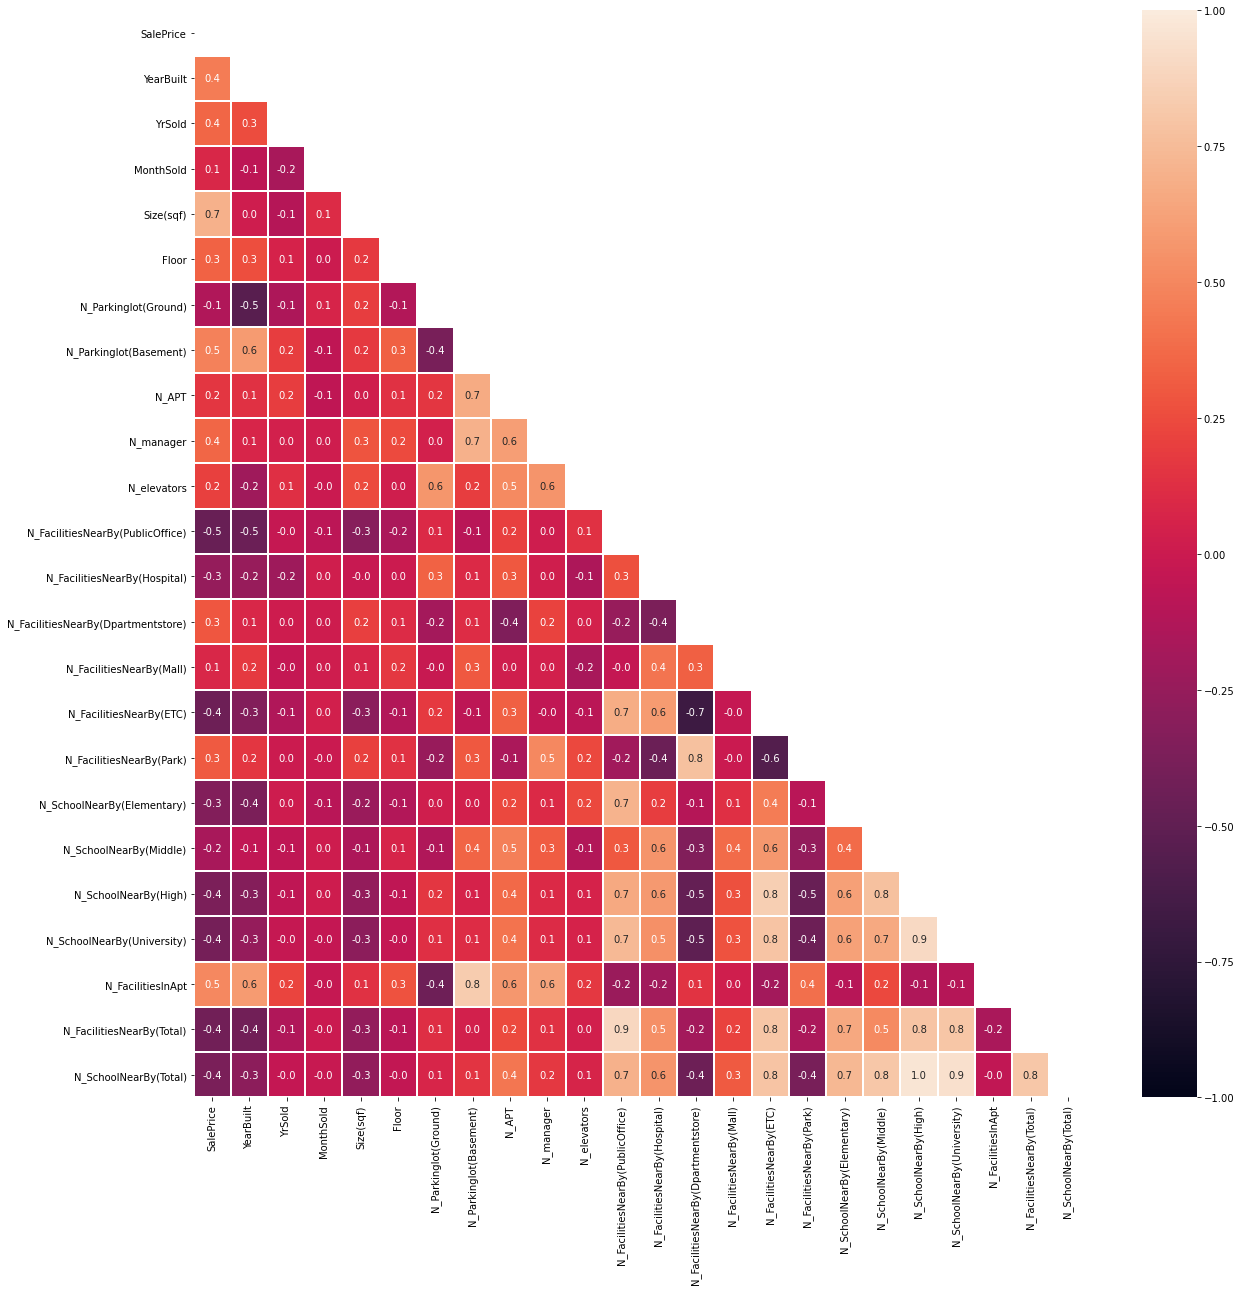

In [12]:
corrMatrix = data.corr()

matrix = np.triu(corrMatrix)
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(corrMatrix, annot=True,mask=matrix, linewidths=1,fmt='.1f',vmin=-1, vmax=1, center=0,cmap='rocket', ax=ax)
plt.show()

In [53]:
#Correlation with output variable
cor_target = abs(corrMatrix["SalePrice"])#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features

SalePrice                           1.000000
YearBuilt                           0.447875
Size(sqf)                           0.697199
N_Parkinglot(Basement)              0.473252
N_FacilitiesNearBy(PublicOffice)    0.462234
N_FacilitiesNearBy(ETC)             0.442299
N_SchoolNearBy(University)          0.403080
N_FacilitiesInApt                   0.505282
N_FacilitiesNearBy(Total)           0.419763
Name: SalePrice, dtype: float64

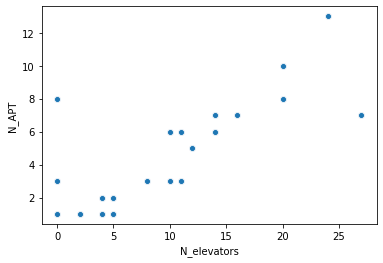

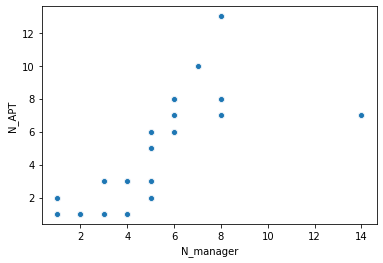

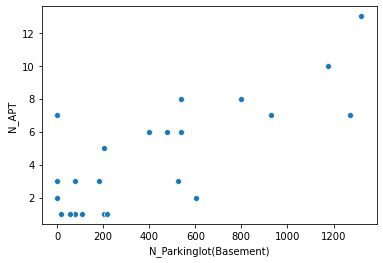

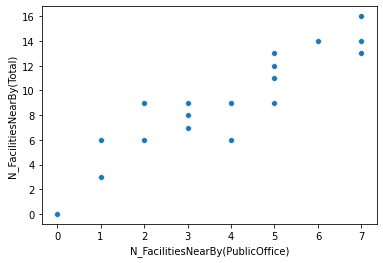

In [14]:
# Interactions between features
sns.scatterplot(x='N_elevators', y='N_APT', data=data)
plt.show(sns)

sns.scatterplot(x='N_manager', y='N_APT', data=data)
plt.show(sns)

sns.scatterplot(x='N_Parkinglot(Basement)', y='N_APT', data=data)
plt.show(sns)

sns.scatterplot(x='N_FacilitiesNearBy(PublicOffice)', y='N_FacilitiesNearBy(Total)', data=data)
plt.show(sns)


# 2. Data Cleaning

In [15]:
# Drop duplicates
data = data.drop_duplicates()
print(data.shape)

(5575, 30)


### No missing values in dataset

In [16]:
data.isnull().sum()

SalePrice                             0
YearBuilt                             0
YrSold                                0
MonthSold                             0
Size(sqf)                             0
Floor                                 0
HallwayType                           0
HeatingType                           0
AptManageType                         0
N_Parkinglot(Ground)                  0
N_Parkinglot(Basement)                0
TimeToBusStop                         0
TimeToSubway                          0
N_APT                                 0
N_manager                             0
N_elevators                           0
SubwayStation                         0
N_FacilitiesNearBy(PublicOffice)      0
N_FacilitiesNearBy(Hospital)          0
N_FacilitiesNearBy(Dpartmentstore)    0
N_FacilitiesNearBy(Mall)              0
N_FacilitiesNearBy(ETC)               0
N_FacilitiesNearBy(Park)              0
N_SchoolNearBy(Elementary)            0
N_SchoolNearBy(Middle)                0


#### Check and  Remove unwanted outliers

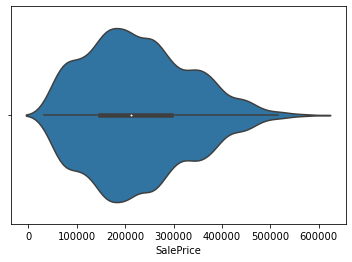

In [17]:
# We use violin plot of 'SalesPrice' using the Seaborn library to show a density estimation of the data.
sns.violinplot(x = 'SalePrice', data=data)
plt.show(sns)

In [18]:
data = data.drop(data.loc[data['SalePrice']>520000].index, axis=0)

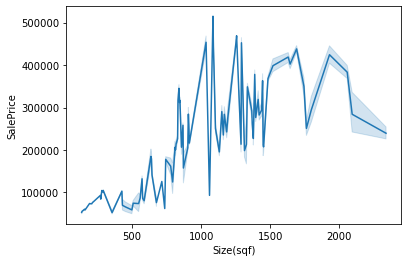

In [19]:
sns.lineplot(x='Size(sqf)',y = 'SalePrice', data=data)
plt.show(sns)

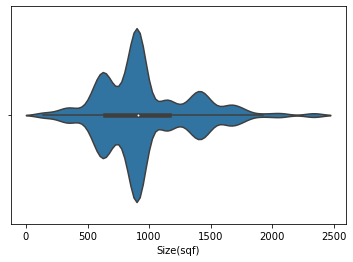

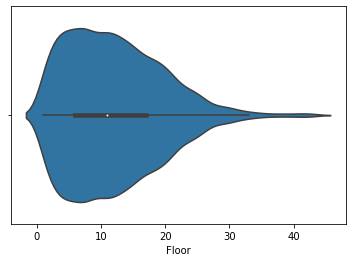

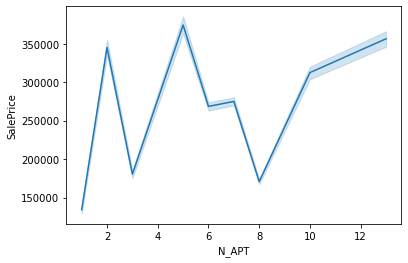

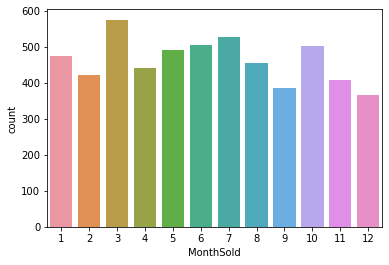

In [20]:

# Violin plot of sqft
sns.violinplot(x='Size(sqf)', data=data)
plt.show()

# Violin plot of Floor
sns.violinplot(x='Floor', data=data)
plt.show()

# Violin plot of N_APT
sns.lineplot(x='N_APT',y="SalePrice", data=data)
plt.show()

# Violin plot of MonthSold
sns.countplot(x='MonthSold', data=data)
plt.show()

# 3. Feature Engineering

In [21]:
def calculate_age(row):
    return row['YrSold'] - row['YearBuilt']

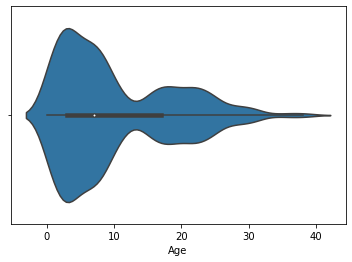

In [22]:
# Violin plot of age
data['Age']= data.apply(calculate_age, axis=1)

sns.violinplot(x='Age', data=data)
plt.show()



In [23]:
data.drop(columns=['YearBuilt','N_elevators','N_manager','MonthSold','N_FacilitiesNearBy(Total)'], axis=1, inplace= True)

data.to_csv('analytical_table.csv', index = False)

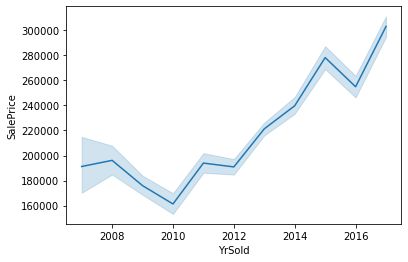

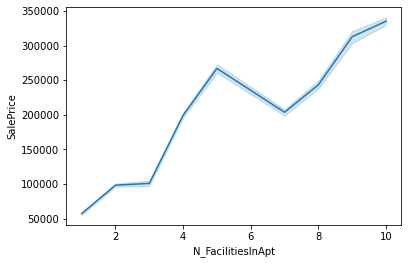

In [24]:
sns.lineplot(x='YrSold',y = 'SalePrice', data=data)
plt.show(sns)

sns.lineplot(x='N_FacilitiesInApt',y = 'SalePrice', data=data)
plt.show(sns)


##### Encode dummy variables

Python machine learning algorithms cannot handle categorical features directly.That's why we need to create dummy variables for our categorical features.

In [26]:
data = pd.get_dummies(data, columns=['HallwayType','HeatingType','AptManageType','TimeToBusStop','TimeToSubway','SubwayStation'], drop_first=True, prefix='')

In [27]:
data.shape

(5548, 37)

# 4. Modeling

The key is choosing machine learning algorithms that can effectively select the best features among many options (built-in feature selection). This will allow you to avoid overfitting our model despite providing many input features. 

In [28]:
y = data.SalePrice

X = data.drop('SalePrice', axis = 1)

In [29]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2,\
                                                    random_state = 72)

In [30]:
print( len(X_train), len(X_test), len(y_train), len(y_test) )

4438 1110 4438 1110


In [31]:
# Summary statistics of X_train
X_train.describe()

,YrSold,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_APT,N_FacilitiesNearBy(PublicOffice),N_FacilitiesNearBy(Hospital),N_FacilitiesNearBy(Dpartmentstore),N_FacilitiesNearBy(Mall),...,_15min~20min,_5min~10min,_no_bus_stop_nearby,_Banwoldang,_Chil-sung-market,_Daegu,_Kyungbuk_uni_hospital,_Myung-duk,_Sin-nam,_no_subway_nearby
count,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,...,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000
mean,2012.694457,962.826273,12.153673,202.970708,552.744254,5.535827,4.118071,1.290446,0.903110,0.939162,...,0.171924,0.187472,0.039658,0.130689,0.020505,0.014872,0.256647,0.274448,0.118297,0.070753
std,2.884982,380.152797,7.577341,218.592610,411.537052,2.867277,1.833756,0.477724,0.819023,0.401028,...,0.377357,0.390334,0.195175,0.337098,0.141735,0.121052,0.436832,0.446286,0.322995,0.256440
min,2007.000000,135.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,644.000000,6.000000,25.000000,184.000000,3.000000,3.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2013.000000,910.000000,11.000000,111.000000,536.000000,7.000000,5.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2015.000000,1149.000000,17.000000,249.000000,798.000000,8.000000,5.000000,2.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,2017.000000,2337.000000,43.000000,713.000000,1321.000000,13.000000,7.000000,2.000000,2.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
pipelines =  {
            'lasso': make_pipeline(RobustScaler(), Lasso(random_state=42)),
            'ridge': make_pipeline(RobustScaler(), Ridge(random_state=42)),
            'elasticnet': make_pipeline(RobustScaler(), ElasticNet(random_state=42)),
            'randomforestregressor': make_pipeline(RobustScaler(),  RandomForestRegressor(random_state=42)),
            'gradientboostingregressor' : make_pipeline(RobustScaler(), GradientBoostingRegressor(random_state=42))}

In [34]:
for key, value in pipelines.items():
    print( key, type(value) )

lasso <class 'sklearn.pipeline.Pipeline'>
ridge <class 'sklearn.pipeline.Pipeline'>
elasticnet <class 'sklearn.pipeline.Pipeline'>
randomforestregressor <class 'sklearn.pipeline.Pipeline'>
gradientboostingregressor <class 'sklearn.pipeline.Pipeline'>


### 4.3. Parameter Tuning

In [35]:
# Lasso hyperparameters
lasso_hyperparameters = {'lasso__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10] }

# Ridge hyperparameters
ridge_hyperparameters = {'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10] }

# Elastic Net hyperparameters
elasticnet_hyperparameters = {
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Random forest hyperparameters
rf_hyperparameters  = {
    'randomforestregressor__n_estimators': [10,50,100,200],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33]
}

# Gradient Boosting hyperparameters
gb_hyperparameters = {
            'gradientboostingregressor__n_estimators' : [10,50,100,200],
            'gradientboostingregressor__learning_rate': [0.05, 0.1,0.2],
            'gradientboostingregressor__max_depth': [1,3,5,10]
}

# Create hyperparameters dictionary
hyperparameters = {
    'randomforestregressor': rf_hyperparameters,
    'gradientboostingregressor': gb_hyperparameters,
    'lasso': lasso_hyperparameters,
    'ridge': ridge_hyperparameters,
    'elasticnet': elasticnet_hyperparameters
}

### 4.4 Model tunning with cross-validation

In [36]:
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv = 10, n_jobs=-1)
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    #model = SelectFromModel(model.estimator.named_steps[name]).fit(X_train, y_train)
    #print(model.get_support(indices=True))
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.Params: {}'.format(model.best_params_))

lasso has been fitted.Params: {'lasso__alpha': 0.001}
ridge has been fitted.Params: {'ridge__alpha': 0.001}
elasticnet has been fitted.Params: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.9}
randomforestregressor has been fitted.Params: {'randomforestregressor__max_features': 0.33, 'randomforestregressor__n_estimators': 200}
gradientboostingregressor has been fitted.Params: {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__n_estimators': 100}


### 4.5. Evaluating models' performance

In [37]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print(name, model.best_score_)

lasso 0.8917097767625665
ridge 0.8917121143453757
elasticnet 0.8914449980089894
randomforestregressor 0.9712823790638087
gradientboostingregressor 0.975493918082534


In [40]:
#The performance of each model in fitted_models on the test set.
for name, model in fitted_models.items():
    print(name)
    print('--------')
    pred = model.predict(X_test)
    print('R^2:', r2_score(y_test, pred))
    print('RMSE: ', np.sqrt(MSE(y_test, pred)))
    print('MAE: ', mean_absolute_error(y_test, pred))
    print('\n')

lasso
--------
R^2: 0.8811898252580759
RMSE:  34840.19453557089
MAE:  25499.768375284028


ridge
--------
R^2: 0.8811881690312241
RMSE:  34840.43737278891
MAE:  25500.22141091727


elasticnet
--------
R^2: 0.8812199819852358
RMSE:  34835.77263768924
MAE:  25490.14712910605


randomforestregressor
--------
R^2: 0.9753274454022908
RMSE:  15876.721010519726
MAE:  10961.236855680987


gradientboostingregressor
--------
R^2: 0.9780501923916883
RMSE:  14975.07868299142
MAE:  10388.84400756127




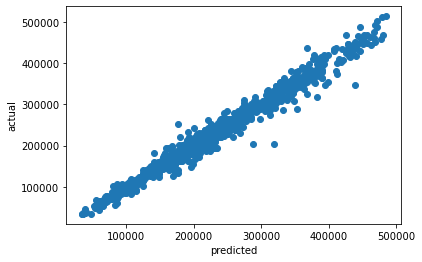

In [48]:
pred = fitted_models['gradientboostingregressor'].predict(X_test)
plt.scatter(pred, y_test)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()



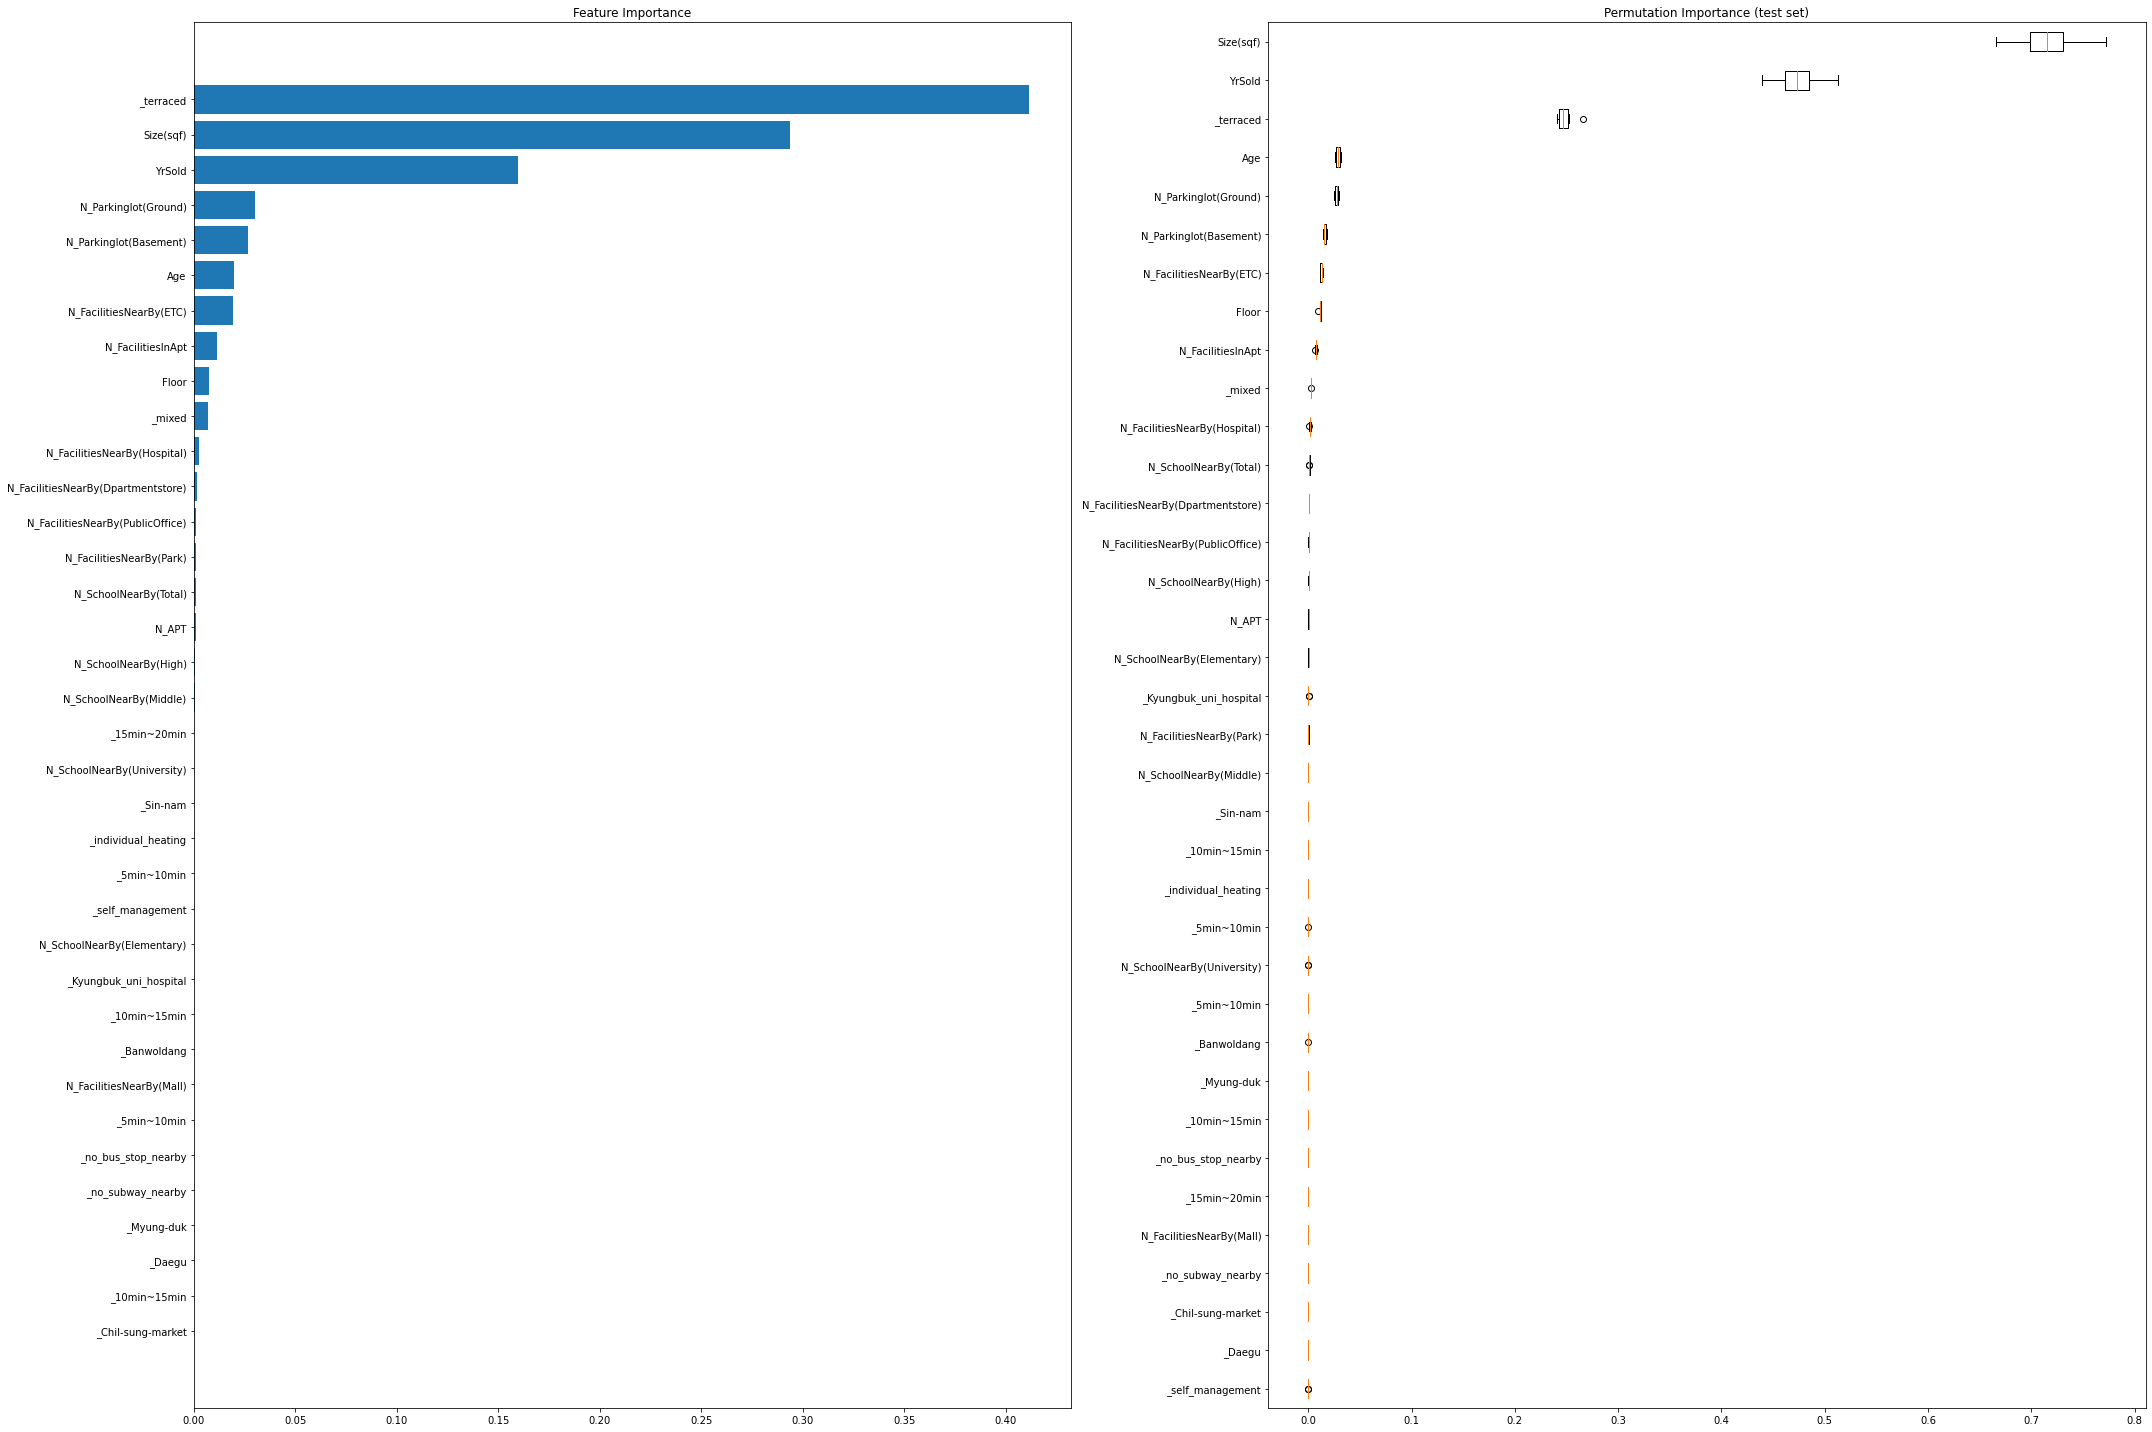

In [54]:
from sklearn.inspection import permutation_importance

# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
gb = GradientBoostingRegressor(n_estimators = 100, max_depth= 5,learning_rate= 0.1)
gb.fit(X_train, y_train)
feature_importance = gb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

result = permutation_importance(gb, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

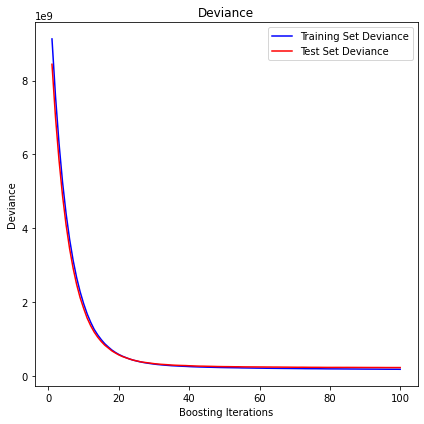

In [51]:
test_score = np.zeros((100,), dtype=np.float64)
for i, y_pred in enumerate(gb.staged_predict(X_test)):
    test_score[i] = gb.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(100) + 1, gb.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(100) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()